# Explore properties of the Poisson distribution

In [37]:
import seaborn as sns
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import spacepy.toolbox as tb

sns.set(font_scale=1.5)


In [2]:
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
with pm.Model() as model:
    p1 = pm.Poisson('p1', 10) #bins, shape=len(bins))
    p2 = pm.Poisson('p2', 15) #bins, shape=len(bins))
    p1_2 = pm.Deterministic('p1_2', p1/p2)
    p12 = pm.Deterministic('p12', p1*p2)

    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p2]
>Metropolis: [p1]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:07<00:00, 5716.01draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb79cf92f90>,
      dtype=object)

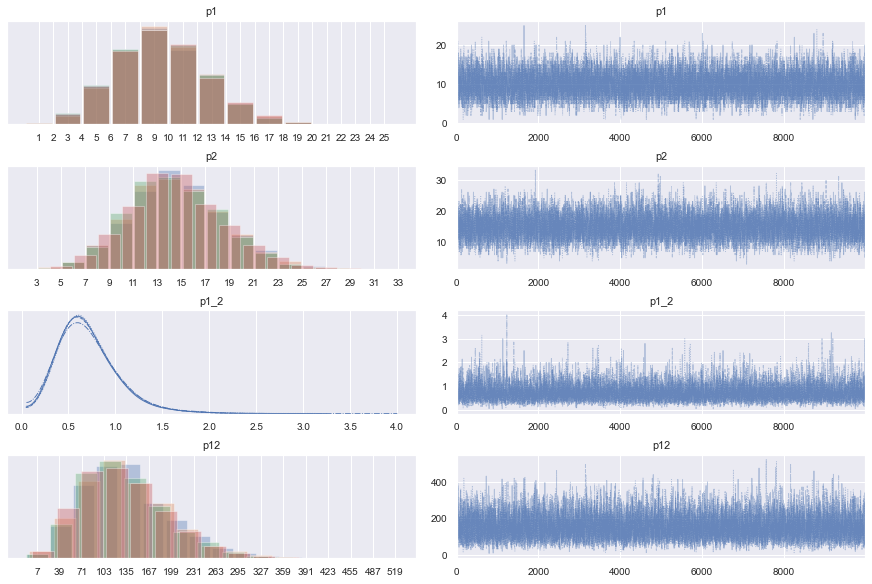

In [3]:
pm.traceplot(trace)

In [4]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p1,10.009,3.169,4.000,15.0,0.035,0.025,8235.0,7910.0,8325.0,9754.0,1.0
p2,15.062,3.866,8.000,22.0,0.044,0.032,7688.0,7528.0,7741.0,8698.0,1.0
p1_2,0.714,0.316,0.222,1.3,0.004,0.002,8066.0,8066.0,8003.0,11524.0,1.0
p12,150.874,63.117,48.000,272.0,0.693,0.491,8288.0,8248.0,8405.0,11717.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb78e091810>,
      dtype=object)

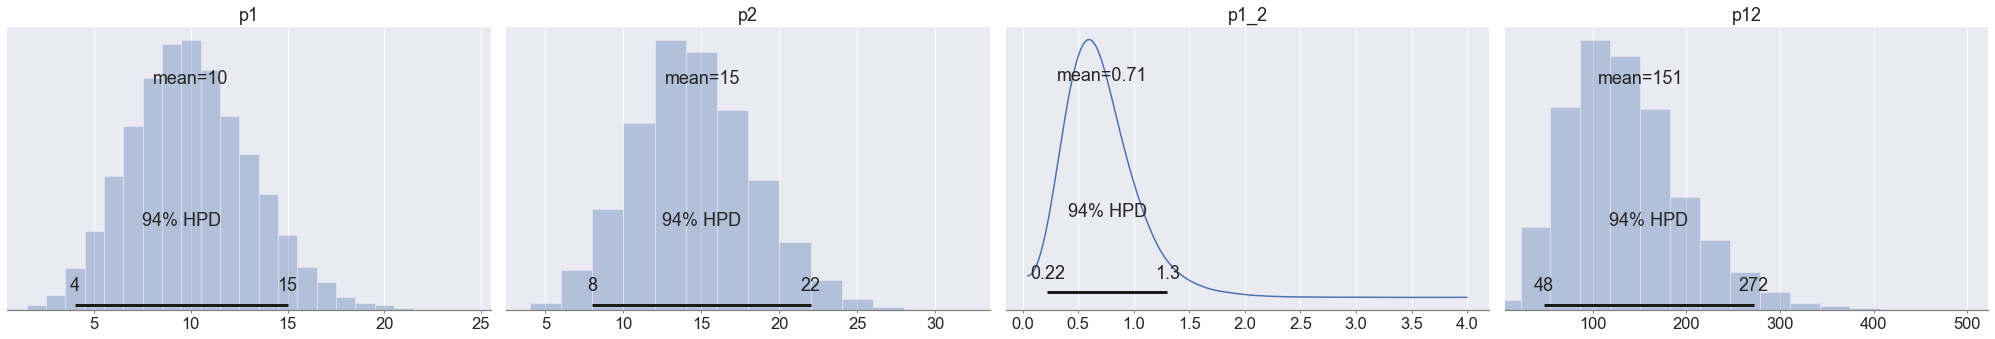

In [5]:
pm.plot_posterior(trace)

# Combine Poissons, can we get a similar answer faster than MCMC?

In [6]:
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
with pm.Model() as model:
    p1 = pm.Poisson('p1', 10) #bins, shape=len(bins))
    p2 = pm.Poisson('p2', 15) #bins, shape=len(bins))
    p3 = pm.Poisson('p3', 21) #bins, shape=len(bins))

    p1_2 = pm.Deterministic('p1_2', (p1+p3)/p2)
    p12 = pm.Deterministic('p12', p1*p2/p3)

    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p3]
>Metropolis: [p2]
>Metropolis: [p1]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:09<00:00, 4390.31draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb784547fd0>,
      dtype=object)

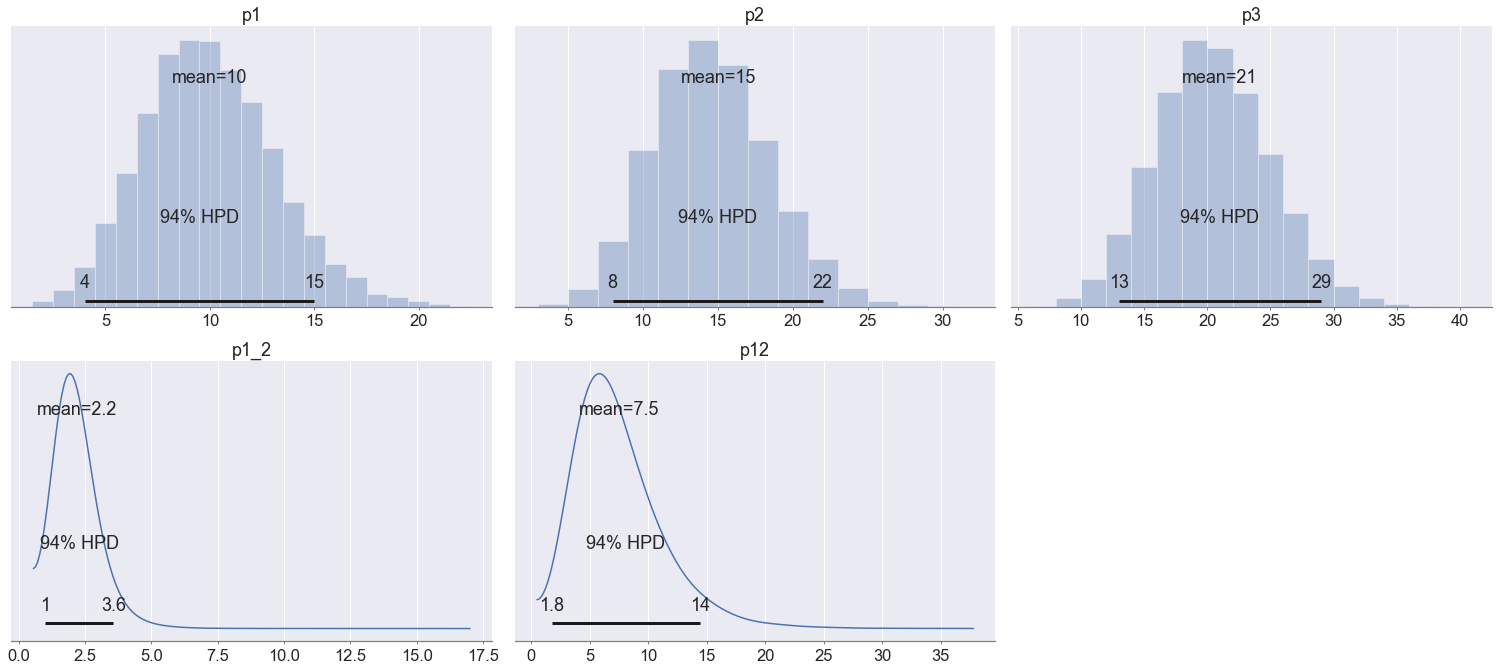

In [7]:
pm.plot_posterior(trace)

In [9]:
p1 = stats.poisson(10)
p2 = stats.poisson(15)
p3 = stats.poisson(21)

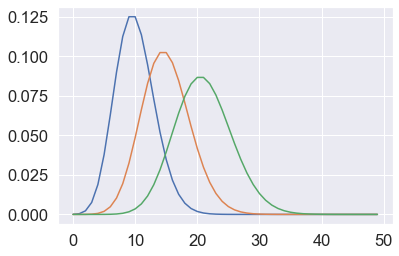

In [15]:
# p1_2 = pm.Deterministic('p1_2', (p1+p3)/p2)
# p12 = pm.Deterministic('p12', p1*p2/p3)
XX = np.arange(50)

plt.plot(XX, p1.pmf(XX))
plt.plot(XX, p2.pmf(XX))
plt.plot(XX, p3.pmf(XX))


# How about summing a bunch of poissons

In [21]:
np.random.seed(8675309)

vals = np.random.poisson(10, size=(16*5*3))


bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
with pm.Model() as model:
    mean = pm.Uniform('mean', 0, 100)
    p_dat = pm.Poisson('p_dat', mean, shape=len(vals), observed=vals)
    
    pmean = pm.Deterministic('pmean', p_dat.mean())

    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:08<00:00, 4964.60draws/s]
The acceptance probability does not match the target. It is 0.8847808455641556, but should be close to 0.8. Try to increase the number of tuning steps.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb758a18790>,
      dtype=object)

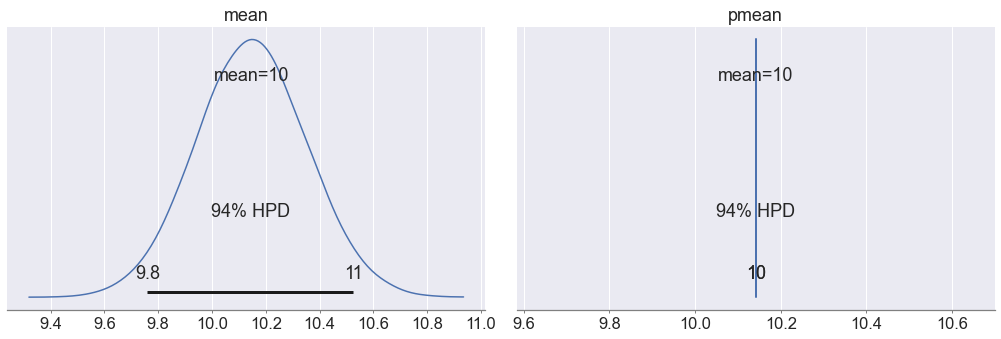

In [22]:
pm.plot_posterior(trace)

TypeError: unsupported operand type(s) for *: 'rv_frozen' and 'int'

## Fit a bunch of measurements to a Poisson

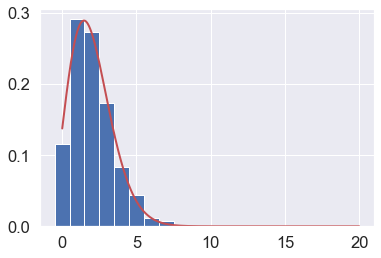

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial


# get poisson deviated random numbers
data = np.random.poisson(2, 1000)

# the bins should be of integer width, because poisson is an integer distribution
entries, bin_edges, patches = plt.hist(data, bins=11, range=[-0.5, 10.5], density=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson, bin_middles, entries) 

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(0, 20, 1000)

plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2)


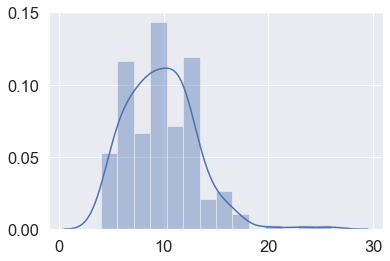

In [34]:
dat = np.random.poisson(10, size=(16*5*3))
sns.distplot(dat)

In [35]:
entries, bin_edges = np.histogram(dat, bins=11, range=[-0.5, 30], density=True)


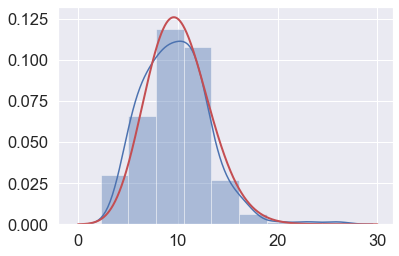

In [41]:
parameters, cov_matrix = curve_fit(poisson, tb.bin_edges_to_center(bin_edges), entries) 
x_plot = np.linspace(0, 30, 1000)

sns.distplot(dat, bin_edges)
plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2)

In [44]:
cov_matrix

array([[0.04225041]])

In [47]:
dat.mean(), dat.mean()-cov_matrix[0][0]*dat.mean(), dat.mean()+cov_matrix[0][0]*dat.mean()

(9.7875, 9.373974148363468, 10.201025851636532)

In [42]:


bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
with pm.Model() as model:
    mean = pm.Uniform('mean', 0, 100)
    p_dat = pm.Poisson('p_dat', mean, observed=dat)
    

    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:08<00:00, 4854.21draws/s]
The acceptance probability does not match the target. It is 0.8816419511836311, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.890431707009551, but should be close to 0.8. Try to increase the number of tuning steps.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb76aa45050>],
      dtype=object)

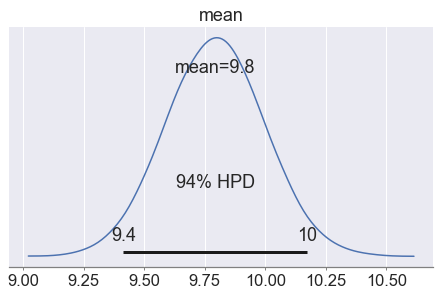

In [43]:
pm.plot_posterior(trace)